In [1]:
import numpy as np
import pandas as pd
from scipy.stats import zscore
import re


import matplotlib.pyplot as plt
import seaborn as sns

import astropy
from astroquery.gaia import Gaia

from pyts.image import GramianAngularField

from fastcore.all import *
from fastai.vision.all import *

In [2]:
# Functions for plotting and saving images


def GADF_image(product, ID, var_type):
    df = product[['time', 'mag', 'band']]
    X = df['mag'].to_numpy().reshape(1, -1)

    gadf = GramianAngularField(method='difference')

    try:
        X_gadf = gadf.fit_transform(X)

        fig = plt.figure(frameon=False)
        fig.set_size_inches(4, 4)

        ax = plt.Axes(fig, [0.0, 0.0, 1.0, 1.0])
        ax.set_axis_off()
        fig.add_axes(ax)

        ax.imshow(X_gadf[0], cmap='rainbow')
        fig.savefig(f'data/GAF/{var_type}/{ID}.png', bbox_inches='tight')
        plt.close(fig)
    except ValueError as err:
        print(f'Error in {var_type} {ID} \n {err=}, {type(err)=}')


def light_curve(product, ID, var_type):
    try:
        fig = plt.figure(frameon=False)
        fig.set_size_inches(4, 4)

        ax = plt.Axes(fig, [0.0, 0.0, 1.0, 1.0])
        ax.set_axis_off()
        fig.add_axes(ax)

        sns.scatterplot(
            x=product['time'],
            y=product['mag'],
            hue=product['band'],
            alpha=0.5,
            ax=ax,
            palette=dict(G='limegreen', BP='blue', RP='red'),
            legend=False,
        )
        inv = ax.invert_yaxis()

        fig.savefig(f'data/light_curve/{var_type}/{ID}.png', bbox_inches='tight')
        plt.close(fig)

    except ValueError as err:
        print(f'Error in {var_type} {ID} \n {err=}, {type(err)=}')

In [3]:
# List of variable types for loops
# Issues running this as AQDL does not work with double quotes, but it is automatically changed during save
var_type_list = [
    'ACV|CP|MCP|ROAM|ROAP|SXARI',
    'ACYG',
    'AGN',
    'BCEP',
    'BE|GCAS|SDOR|WR',
    'CEP',
    'CV',
    'DSCT|GDOR|SXPHE',
    'ECL',
    'ELL',
    'EP',
    'LPV',
    'MICROLENSING',
    'RCB',
    'RR',
    'RS',
    'S',
    'SDB',
    'SN',
    'SOLAR_LIKE',
    'SPB',
    'SYST',
    'WD',
    'YSO',
]
var_type_list_short = [
    'ACV|CP|MCP|ROAM|ROAP|SXARI',
    # 'ACYG',
    'AGN',
    'BCEP',
    'BE|GCAS|SDOR|WR',
    'CEP',
    'CV',
    'DSCT|GDOR|SXPHE',
    'ECL',
    'ELL',
    # 'EP',
    'LPV',
    # 'MICROLENSING',
    # 'RCB',
    'RR',
    'RS',
    'S',
    # 'SDB',
    'SN',
    'SOLAR_LIKE',
    'SPB',
    # 'SYST',
    # 'WD',
    'YSO',
]
var_type_list_pulse = ['CEP', 'RR']

var_type_folder_list = [
    'ACV_CP_MCP_ROAM_ROAP_SXARI',
    'ACYG',
    'AGN',
    'BCEP',
    'BE_GCAS_SDOR_WR',
    'CEP',
    'CV',
    'DSCT_GDOR_SXPHE',
    'ECL',
    'ELL',
    'EP',
    'LPV',
    'MICROLENSING',
    'RCB',
    'RR',
    'RS',
    'S',
    'SDB',
    'SN',
    'SOLAR_LIKE',
    'SPB',
    'SYST',
    'WD',
    'YSO',
]


In [4]:
var_type_list = [
    'RS',
    'S',
    'SDB',
    'SN',
    'SOLAR_LIKE',
    'SPB',
    'SYST',
    'WD',
    'YSO',
]

var_type_folder_list = [
    'RS',
    'S',
    'SDB',
    'SN',
    'SOLAR_LIKE',
    'SPB',
    'SYST',
    'WD',
    'YSO',
]

In [5]:
    # Keep this in case we want to retrieve periods
    '''
    if var_type == 'cepheid':
        query = f'SELECT TOP {n_stars} source_id, pf, p1_o, p2_o, epoch_g \
            FROM gaiadr3.vari_cepheid'
    elif var_type == 'rrlyrae':
        query = f'SELECT TOP {n_stars} source_id, pf, p1_o, epoch_g \
            FROM gaiadr3.vari_rrlyrae'
    '''

"\nif var_type == 'cepheid':\n    query = f'SELECT TOP {n_stars} source_id, pf, p1_o, p2_o, epoch_g         FROM gaiadr3.vari_cepheid'\nelif var_type == 'rrlyrae':\n    query = f'SELECT TOP {n_stars} source_id, pf, p1_o, epoch_g         FROM gaiadr3.vari_rrlyrae'\n"

In [6]:
# Retrieve data from Gaia Database and download locally

# Number of stars to retrieve (max 5000)
n_stars = 5000

# Create directories to store the images
path_GAF = Path('data/GAF')
path_lc = Path('data/light_curve')

for o in var_type_folder_list:
    dest = path_GAF / o
    dest.mkdir(exist_ok=True, parents=True)
    dest = path_lc / o
    dest.mkdir(exist_ok=True, parents=True)

# Main body of the code
for var_type in var_type_list:
    # Query the vari_classifier_result table for a specfic variable type (up to n_stars)
    print(f"var_type: {var_type}")
    query = f"SELECT TOP {n_stars} source_id, best_class_name \
        FROM gaiadr3.vari_classifier_result \
        WHERE best_class_name = '{var_type}'"

    # query = f'SELECT TOP 200 source_id, classifier_name, best_class_name \
    # FROM gaiadr3.vari_classifier_result'

    job = Gaia.launch_job_async(query)
    results = job.get_results()

    df_results = results.to_pandas()
    # Replace missing periods with the period of the first overtone
    # df_results['pf'] = df_results['pf'].fillna(df_results['p1_o'])

    retrieval_type = 'EPOCH_PHOTOMETRY'  # Options are: 'EPOCH_PHOTOMETRY', 'MCMC_GSPPHOT', 'MCMC_MSC', 'XP_SAMPLED', 'XP_CONTINUOUS', 'RVS', 'ALL'
    data_structure = 'INDIVIDUAL'  # Options are: 'INDIVIDUAL', 'COMBINED', 'RAW'
    data_release = 'Gaia DR3'  # Options are: 'Gaia DR3' (default), 'Gaia DR2'

    datalink = Gaia.load_data(
        ids=df_results['SOURCE_ID'],
        data_release=data_release,
        retrieval_type=retrieval_type,
        data_structure=data_structure,
        verbose=False,
        output_file=None,
        format='csv',
    )

    for ID in df_results['SOURCE_ID']:
        # Define the period corresponding to the fundamental pulsation mode
        # period_f = df_results[df_results['SOURCE_ID'] == ID]['pf'].values[0]
        # Define the arbitrary start point of the phase, epoch of the maximum of the light curve in the G band
        # epoch_g = df_results[df_results['SOURCE_ID'] == ID]['epoch_g'].values[0]

        dl_key = f'EPOCH_PHOTOMETRY-Gaia DR3 {ID}.csv'

        product = datalink[dl_key][0]
        # product['phase'] = (product['time'] - epoch_g) % period_f
        # print(product.columns)
        # Remove data points rejected by the variability pipeline
        # product = product[product['rejected_by_variability'] == False]
        product = product.to_pandas().dropna()
        product = product[product['rejected_by_variability'] == 'false']

        # print(product)
        # GADF_image(product, ID, var_type)
        var_type = re.sub(r'\|', '_', var_type)
        light_curve(product, ID, var_type)

var_type: RS
INFO: Query finished. [astroquery.utils.tap.core]


var_type: S
INFO: Query finished. [astroquery.utils.tap.core]


var_type: SDB
INFO: Query finished. [astroquery.utils.tap.core]


var_type: SN
INFO: Query finished. [astroquery.utils.tap.core]


var_type: SOLAR_LIKE
INFO: Query finished. [astroquery.utils.tap.core]


var_type: SPB
INFO: Query finished. [astroquery.utils.tap.core]


var_type: SYST
INFO: Query finished. [astroquery.utils.tap.core]


var_type: WD
INFO: Query finished. [astroquery.utils.tap.core]


var_type: YSO
INFO: Query finished. [astroquery.utils.tap.core]


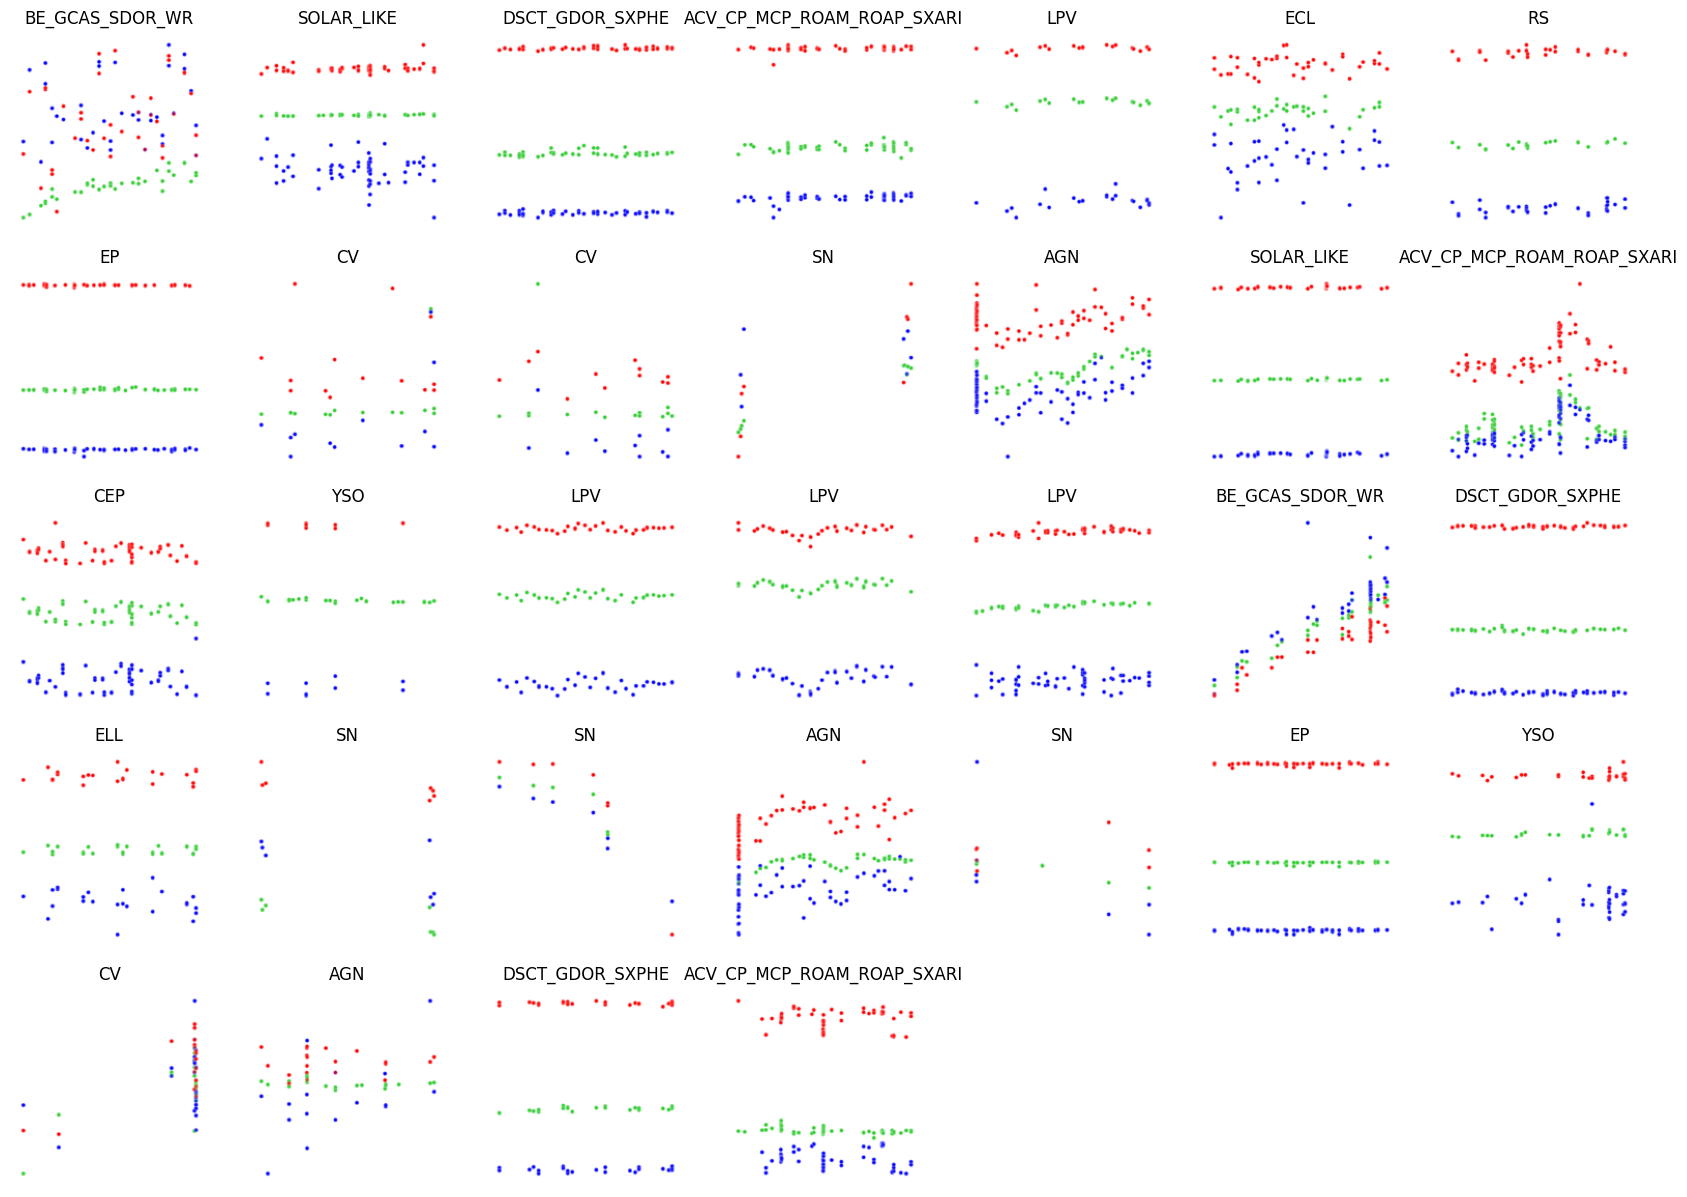

In [9]:
# Original size for resize was 192. 250 gives better resolution

dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    # Inputs for our model are images, outputs are categories (bird or forest)
    get_items=get_image_files,
    # Returns a list of all images in the path
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    # Split the data into training and validation sets, using 20% for validation
    get_y=parent_label,
    # The label for each image is the name of the folder it's in
    item_tfms=[Resize(192, method='squish')],
    # Resize each image to 192x192 pixels by squishing instead of cropping
).dataloaders(path_lc, bs=32)

dls.show_batch(max_n=40)

---
### Resnet18
---

In [11]:
# Set seed, try different resnets

learn = vision_learner(dls, resnet18, metrics=error_rate)
# Create a model using the data in `dls`, using the ResNet18 architecture
learn.fine_tune(3)
# Fine-tune the model for 3 epochs

epoch,train_loss,valid_loss,error_rate,time
0,1.300993,1.076330,0.350120,1:23:46


epoch,train_loss,valid_loss,error_rate,time
0,0.815843,0.714373,0.235625,1:18:40
1,0.566259,0.510727,0.168773,1:20:24
2,0.335936,0.451610,0.151017,1:16:53


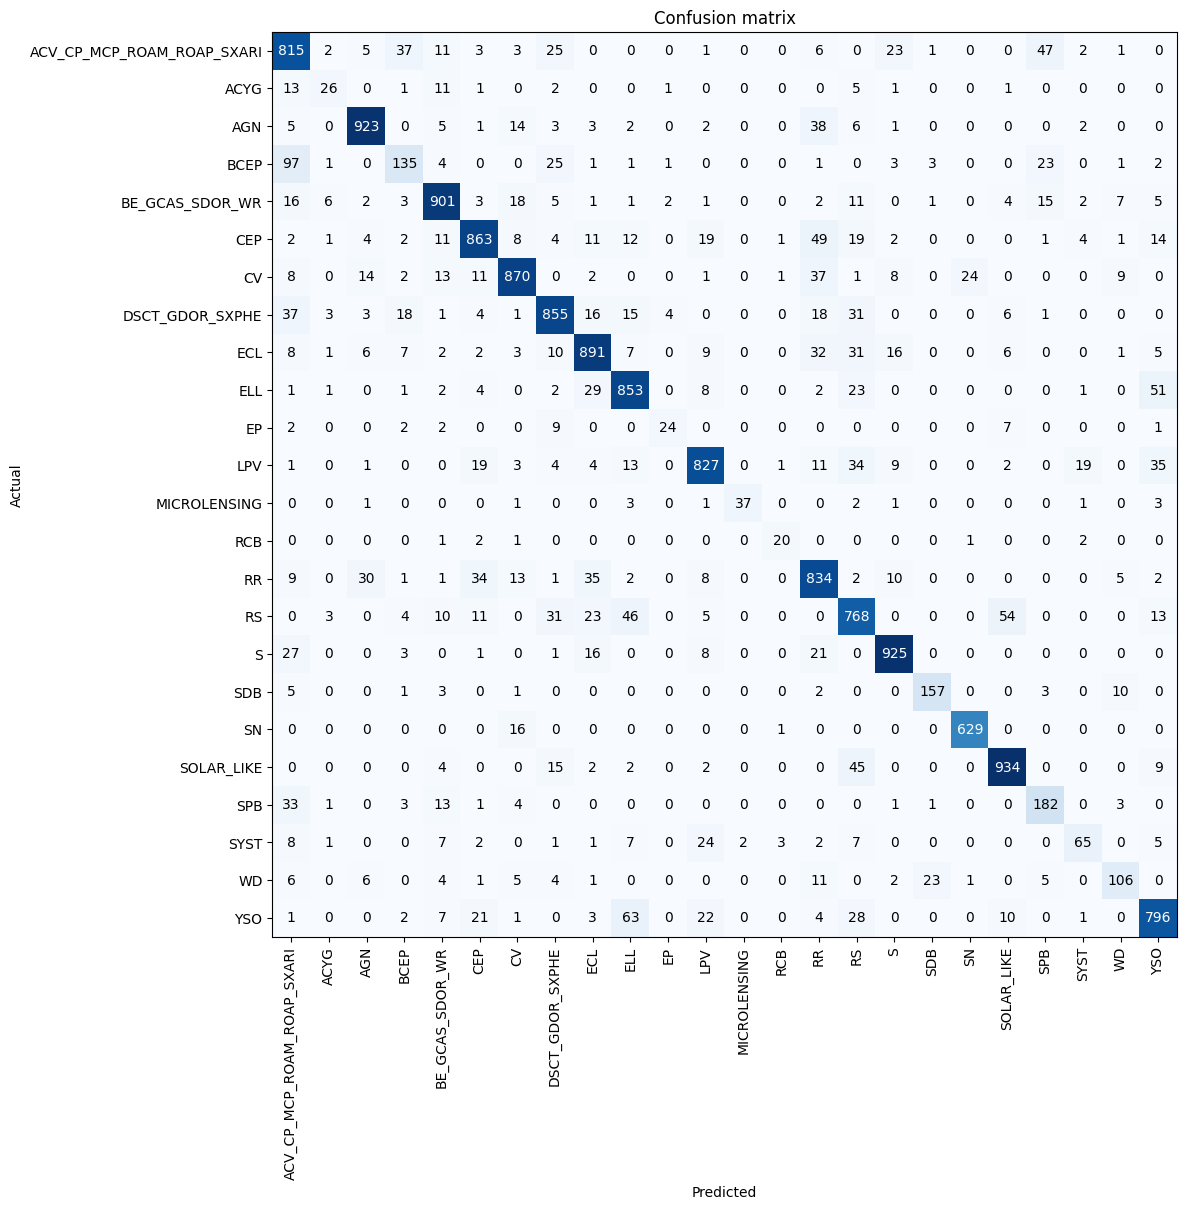

In [15]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12))

<Figure size 2500x2500 with 0 Axes>

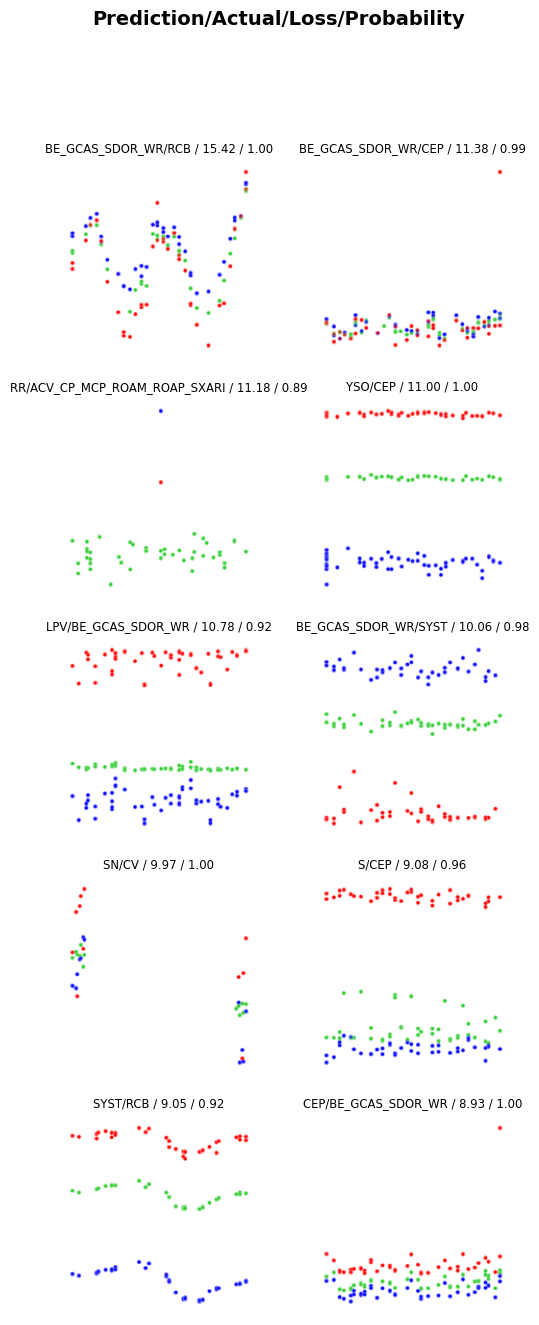

In [22]:
plt.figure(figsize=(25, 25))
plt.rcParams.update({'font.size': 7})
interp.plot_top_losses(10, nrows=5)

---
### Resnet34
---

# Set seed, try different resnets

learn = vision_learner(dls, resnet34, metrics=error_rate)
# Create a model using the data in `dls`, using the ResNet18 architecture
learn.fine_tune(3)
# Fine-tune the model for 3 epochs

interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

interp.plot_top_losses(5, nrows=1)